In [5]:
%pip install --upgrade pandas numpy scikit-learn xgboost matplotlib seaborn

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import xgboost as xgb 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


354605.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached numpy-2.3.0-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:

pd.options.display.float_format = '{:,.0f}'.format # Used to display float numbers in pandas with 0 decimal places and normal commas
# Defining Time Range and Adjusting the dataframe for dataset
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

engagement_df = pd.DataFrame(index=date_range) # For creating a dataset

daily_views = 350000  # Average Daily Views For a Big Content Creator Level Channel
growth_rate = np.linspace(1,1.15,len(engagement_df)) # Simulate 15% growth every 2 years
weekly_pattern =  np.array([0.95, 1.05, 1.05, 1.05, 1.05, 0.85, 0.9]) # Weekly boost (dip on Saturaday & Sunday)
annual_pattern = np.sin(np.linspace(0, 2*np.pi*2, len(engagement_df))) * 0.10 + 1 # Generates a smooth yearly wave pattern(higher views during academic season and lower during breaks)- Around 10%
random_fluctuations = np.random.normal(0, 25000, len(engagement_df)) # Adds random and unpredictable Fluctuations (0 - 25000 is done since a big channel is taken into account)
engagement_df['Views'] = daily_views * growth_rate * weekly_pattern[engagement_df.index.dayofweek] * annual_pattern + random_fluctuations # Creates the inital Views Column by multiplying the 'daily_views' by the 'growth_rate', applies the 'weekly_pattern' and 'annual_pattern' based on the date, and then adds 'random_fluctuations'
engagement_df['Views'] = engagement_df['Views'].apply(lambda x: max(50000, x)) # Ensuring no daily views count dont drop below 50000 ( Large Channel )

release_frequency_days = 30 # Releasing a video every month
release_dates = engagement_df.index[::release_frequency_days] # will help to identify specific dates in dataset to considered release dates

# Using loop to apply spikes for new video release
for date in release_dates:
    # Simulate a large initial spike on release day for big channels
    engagement_df.loc[date, 'Views'] += np.random.normal(2_000_000, 600_000) # Add 2M - 0.6M views

    # Simulate decay over the next 30 days
    for i in range(1, 31): # Loop from day 1 to day 30 after release
        decay_factor = 0.95 ** i # Exponential decay, 5% less than previous day
        if date + timedelta(days=i) <= engagement_df.index.max(): # Add decaying views for the days following the release
            engagement_df.loc[date + timedelta(days=i), 'Views'] += np.random.normal(1_500_000 * decay_factor, 200_000) # Targets the view cell for the date we are calculating decay for

# Convert 'Date' index back to a regular column for saving
engagement_df = engagement_df.reset_index().rename(columns={'index': 'Date'})

# # Save your DataFrame to a CSV file
# engagement_df.to_csv('simulated_physics_engagement.csv', index=False)

# print(f"Generated a dataset with {len(engagement_df)} rows and saved to 'simulated_physics_engagement.csv'.")
# print("First 5 rows of generated data:")
# print(engagement_df.head())

In [7]:
engagement_df = pd.read_csv("simulated_physics_engagement.csv")
engagement_df['Date'] = pd.to_datetime(engagement_df['Date']) # this line here convert the Date column from dataset into a datetime object by converting strings into a format which pandas can use to understand and perform datetime operations
engagement_df = engagement_df.set_index('Date') # Make the Date column as index 
print('First five lines data after loading and indexing')
print(engagement_df.head())
print(f"\nThe DataFrame currently has {engagement_df.shape[0]} rows and {engagement_df.shape[1]} column(s).")

First five lines data after loading and indexing
               Views
Date                
2023-01-01 2,166,697
2023-01-02 1,508,327
2023-01-03 1,846,483
2023-01-04 1,855,636
2023-01-05 1,261,890

The DataFrame currently has 731 rows and 1 column(s).


In [8]:
engagement_df['days_of_week'] = engagement_df.index.dayofweek #the method returns an integer with Monday=0,Tuesday=1 and since my data has weekly patterns
engagement_df['days_of_year'] = engagement_df.index.dayofyear
engagement_df['week_of_year'] = engagement_df.index.isocalendar().week.astype(int)
engagement_df['month'] = engagement_df.index.month
engagement_df['year'] = engagement_df.index.year

engagement_df['is_weekend'] = engagement_df['days_of_week'].isin([5, 6]).astype(int)

engagement_df['quarter'] = engagement_df.index.quarter

# Print a header for clarity.
print("\n--- Time-Based Features Added ---")
# Print the first 5 rows again to show the newly added columns.
print("First 5 rows of your DataFrame with the new time features:")
print(engagement_df.head())
# Print the updated DataFrame shape to confirm more columns have been added.
print(f"\nNow your DataFrame has {engagement_df.shape[1]} columns (more features!).")


--- Time-Based Features Added ---
First 5 rows of your DataFrame with the new time features:
               Views  days_of_week  days_of_year  week_of_year  month  year  \
Date                                                                          
2023-01-01 2,166,697             6             1            52      1  2023   
2023-01-02 1,508,327             0             2             1      1  2023   
2023-01-03 1,846,483             1             3             1      1  2023   
2023-01-04 1,855,636             2             4             1      1  2023   
2023-01-05 1,261,890             3             5             1      1  2023   

            is_weekend  quarter  
Date                             
2023-01-01           1        1  
2023-01-02           0        1  
2023-01-03           0        1  
2023-01-04           0        1  
2023-01-05           0        1  

Now your DataFrame has 8 columns (more features!).


In [9]:
#line creates 'views_lag_1', which contains the 'Views' from the previous day
#shift()' is a Pandas method that moves the entire column down by n row.
#typically the strongest predictor for current views because views tend to be correlated day-to-day.
engagement_df['views_lag_1'] = engagement_df['Views'].shift(1) 

#This helps the model capture the weekly seasonality you've built into your data (e.g., Sunday views might be related to previous Sunday's views).
engagement_df['views_lag_7'] = engagement_df['Views'].shift(7)

for i in range(2, 7):
    engagement_df[f'views_lag_{i}'] = engagement_df['Views'].shift(i)

engagement_df['views_rolling_mean_7'] = engagement_df['Views'].rolling(window=7).mean().shift(1)

engagement_df['views_rolling_std_7'] = engagement_df['Views'].rolling(window=7).std().shift(1)


print("\n--- Lag and Rolling Mean Features Added ---")

print("First 10 rows with new lag and rolling features (notice 'NaN' values at the top):")
print(engagement_df.head(10))


--- Lag and Rolling Mean Features Added ---
First 10 rows with new lag and rolling features (notice 'NaN' values at the top):
               Views  days_of_week  days_of_year  week_of_year  month  year  \
Date                                                                          
2023-01-01 2,166,697             6             1            52      1  2023   
2023-01-02 1,508,327             0             2             1      1  2023   
2023-01-03 1,846,483             1             3             1      1  2023   
2023-01-04 1,855,636             2             4             1      1  2023   
2023-01-05 1,261,890             3             5             1      1  2023   
2023-01-06 1,629,527             4             6             1      1  2023   
2023-01-07 1,166,828             5             7             1      1  2023   
2023-01-08 1,344,564             6             8             1      1  2023   
2023-01-09 1,724,726             0             9             2      1  2023   
2023

In [10]:
initial_rows_with_nan = engagement_df.isnull().sum().max()
engagement_df.dropna(inplace=True)
print(f"\n--- Handling Missing Values ---")
# Confirm how many rows were removed, which helps you understand the data loss.
print(f"Removed {initial_rows_with_nan} rows that contained NaN values (typically from lag features).")
# Print the final shape of the DataFrame after cleaning to show the reduced number of rows.
print(f"DataFrame shape after dropping NaNs: {engagement_df.shape}")
# Print the first 5 rows of the cleaned DataFrame to show that there are no more NaNs at the top.
print("First 5 rows of the cleaned DataFrame (no NaNs):")
print(engagement_df.head())



--- Handling Missing Values ---
Removed 7 rows that contained NaN values (typically from lag features).
DataFrame shape after dropping NaNs: (724, 17)
First 5 rows of the cleaned DataFrame (no NaNs):
               Views  days_of_week  days_of_year  week_of_year  month  year  \
Date                                                                          
2023-01-08 1,344,564             6             8             1      1  2023   
2023-01-09 1,724,726             0             9             2      1  2023   
2023-01-10 1,447,971             1            10             2      1  2023   
2023-01-11 1,268,377             2            11             2      1  2023   
2023-01-12 1,205,494             3            12             2      1  2023   

            is_weekend  quarter  views_lag_1  views_lag_7  views_lag_2  \
Date                                                                     
2023-01-08           1        1    1,166,828    2,166,697    1,629,527   
2023-01-09           0 

In [11]:
# I took January 1,2024 as the cut off date(split point). All data before this date will be for training,and all data from or after this date will be for testing.
split_date = datetime(2024, 1, 1) # This means the model learns from all of 2023's data to predict 2024's data.
clues  = engagement_df.drop('Views', axis = 1) #'engagement_df.drop('Views', axis=1)' means: take the whole table, and remove the 'Views' column.
views_actual = engagement_df['Views'] #This is the column we want to predict – 'Views

#If a date is earlier than Jan 1, 2024, the result for that date will be 'True'.
# If a date is on or after Jan 1, 2024, the result for that date will be 'False'.
# This 'train_mask' will be a long list of True/False values, one for each date
train_mask = clues.index < split_date  # Line created for T/F based on my dates , clues.index refers to dateindex of my dataframe. 
clues_train = clues[train_mask] # Only rows where train_mask is true will be selcted in clues_train i.e all dates in 2023
views_actual_train = views_actual[train_mask] # To select corresponding target for training, will contain actual 'Views' for dates in 2023
# This code lines will help me -(clues_train - the model learns from) and (views_actual_train - the correct answers my model learns from)

test_mask = clues.index >= split_date # Indicator for which dates will be in my testing list, (Use it for testing- True and Dont - False)


In [12]:
clues_test = clues[test_mask] # this will select the rows from clues table where the test_mask is true 
views_actual_test = views_actual[test_mask] #Will select the corresponding answers for test 



In [13]:
print("--- Data Split Confirmed ---")

# Print the date range for your training data (X_train.index and y_train.index are the same).
# '.min()' gets the earliest date, '.max()' gets the latest date.
# '.strftime('%Y-%m-%d')' formats the date nicely as YYYY-MM-DD.
print(f"Training data range: {clues_train.index.min().strftime('%Y-%m-%d')} to {clues_train.index.max().strftime('%Y-%m-%d')}")

# Do the same for your testing data.
print(f"Testing data range:  {clues_test.index.min().strftime('%Y-%m-%d')} to {clues_test.index.max().strftime('%Y-%m-%d')}")

# Print the dimensions (shape) of your training sets.
# '.shape' returns a tuple (number of rows, number of columns).
print(f"Training data size (rows, columns): {clues_train.shape}")

# Print the dimensions of your testing sets.
print(f"Testing data size (rows, columns): {clues_test.shape}")

--- Data Split Confirmed ---
Training data range: 2023-01-08 to 2023-12-31
Testing data range:  2024-01-01 to 2024-12-31
Training data size (rows, columns): (358, 16)
Testing data size (rows, columns): (366, 16)


In [14]:
# CODE BLOCK 6: Model Selection and Training (Using xgboost.train)

import xgboost as xgb # Make sure xgboost is imported for this part.

# Part 1: Convert your data to DMatrix format
# This converts your Pandas DataFrames into XGBoost's highly optimized internal data format.
dtrain = xgb.DMatrix(clues_train, label=views_actual_train)
dvalid = xgb.DMatrix(clues_test, label=views_actual_test)

# Part 2: Define Parameters for Training
# These are the configuration settings for your XGBoost model.
params = {
    "objective": "reg:squarederror", # The model's goal: minimize squared prediction errors.
    "eval_metric": "rmse",           # The metric to monitor during training for evaluation.
    "learning_rate": 0.05,           # Controls how much the model adjusts its understanding each step.
    "seed": 42,                      # Sets the random seed for reproducible results.
}

# Part 3: Set up Evaluation Sets for Monitoring
# These are the datasets XGBoost will check its performance on during training (train and validation/test).
evals = [(dtrain, "train"), (dvalid, "validation")]

# Part 4: Train the Model with Early Stopping
# This line starts the training process.
model = xgb.train(
    params,                          # The learning parameters.
    dtrain,                          # Your training data in DMatrix format.
    num_boost_round=1000,            # Maximum number of boosting rounds (trees).
    evals=evals,                     # The evaluation sets for monitoring.
    early_stopping_rounds=50,        # Stops training if performance doesn't improve for 50 rounds.
    verbose_eval=True                # Set to True to see training progress in the output.
)

print("\n--- XGBoost 'Brain' Trained Successfully ---")
# 'model.best_iteration' shows the optimal number of trees used.
print(f"Best iteration (number of trees used by the brain): {model.best_iteration}")


[0]	train-rmse:461178.11730	validation-rmse:501518.01810
[1]	train-rmse:448000.52186	validation-rmse:496040.69340
[2]	train-rmse:435573.42422	validation-rmse:491228.24435
[3]	train-rmse:423933.30315	validation-rmse:486917.85921
[4]	train-rmse:412975.12574	validation-rmse:483262.92533
[5]	train-rmse:402530.35823	validation-rmse:479804.96703
[6]	train-rmse:392736.81056	validation-rmse:476434.95837
[7]	train-rmse:383630.17708	validation-rmse:473974.32555
[8]	train-rmse:374386.17367	validation-rmse:471385.21219
[9]	train-rmse:365693.90221	validation-rmse:469101.07252
[10]	train-rmse:357974.70354	validation-rmse:467236.97952
[11]	train-rmse:351191.08979	validation-rmse:465689.47743
[12]	train-rmse:340792.11049	validation-rmse:463736.45997
[13]	train-rmse:331002.55648	validation-rmse:461804.65569
[14]	train-rmse:321680.56531	validation-rmse:460407.58916
[15]	train-rmse:316113.69950	validation-rmse:459715.22005
[16]	train-rmse:309307.78932	validation-rmse:457251.75815
[17]	train-rmse:302782.4

In [15]:
predictions = model.predict(dvalid)
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate Mean Absolute Error (MAE).
# It's the average absolute difference between the actual views (views_actual_test) and the predicted views (predictions).
mae = mean_absolute_error(views_actual_test, predictions)

# Calculate Root Mean Squared Error (RMSE).
# First, we calculate Mean Squared Error (mean_squared_error), which squares the differences.
# Then, we take the square root of that result (np.sqrt) to get RMSE, putting it back in the same units as views.
rmse = np.sqrt(mean_squared_error(views_actual_test, predictions))

# Print the calculated metrics, formatted nicely for readability.
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:,.0f}") # Formatted with comma for thousands, 0 decimal places.
print(f"Root Mean Squared Error (RMSE): {rmse:,.0f}") # Formatted with comm


Model Evaluation Metrics:
Mean Absolute Error (MAE): 271,145
Root Mean Squared Error (RMSE): 435,149


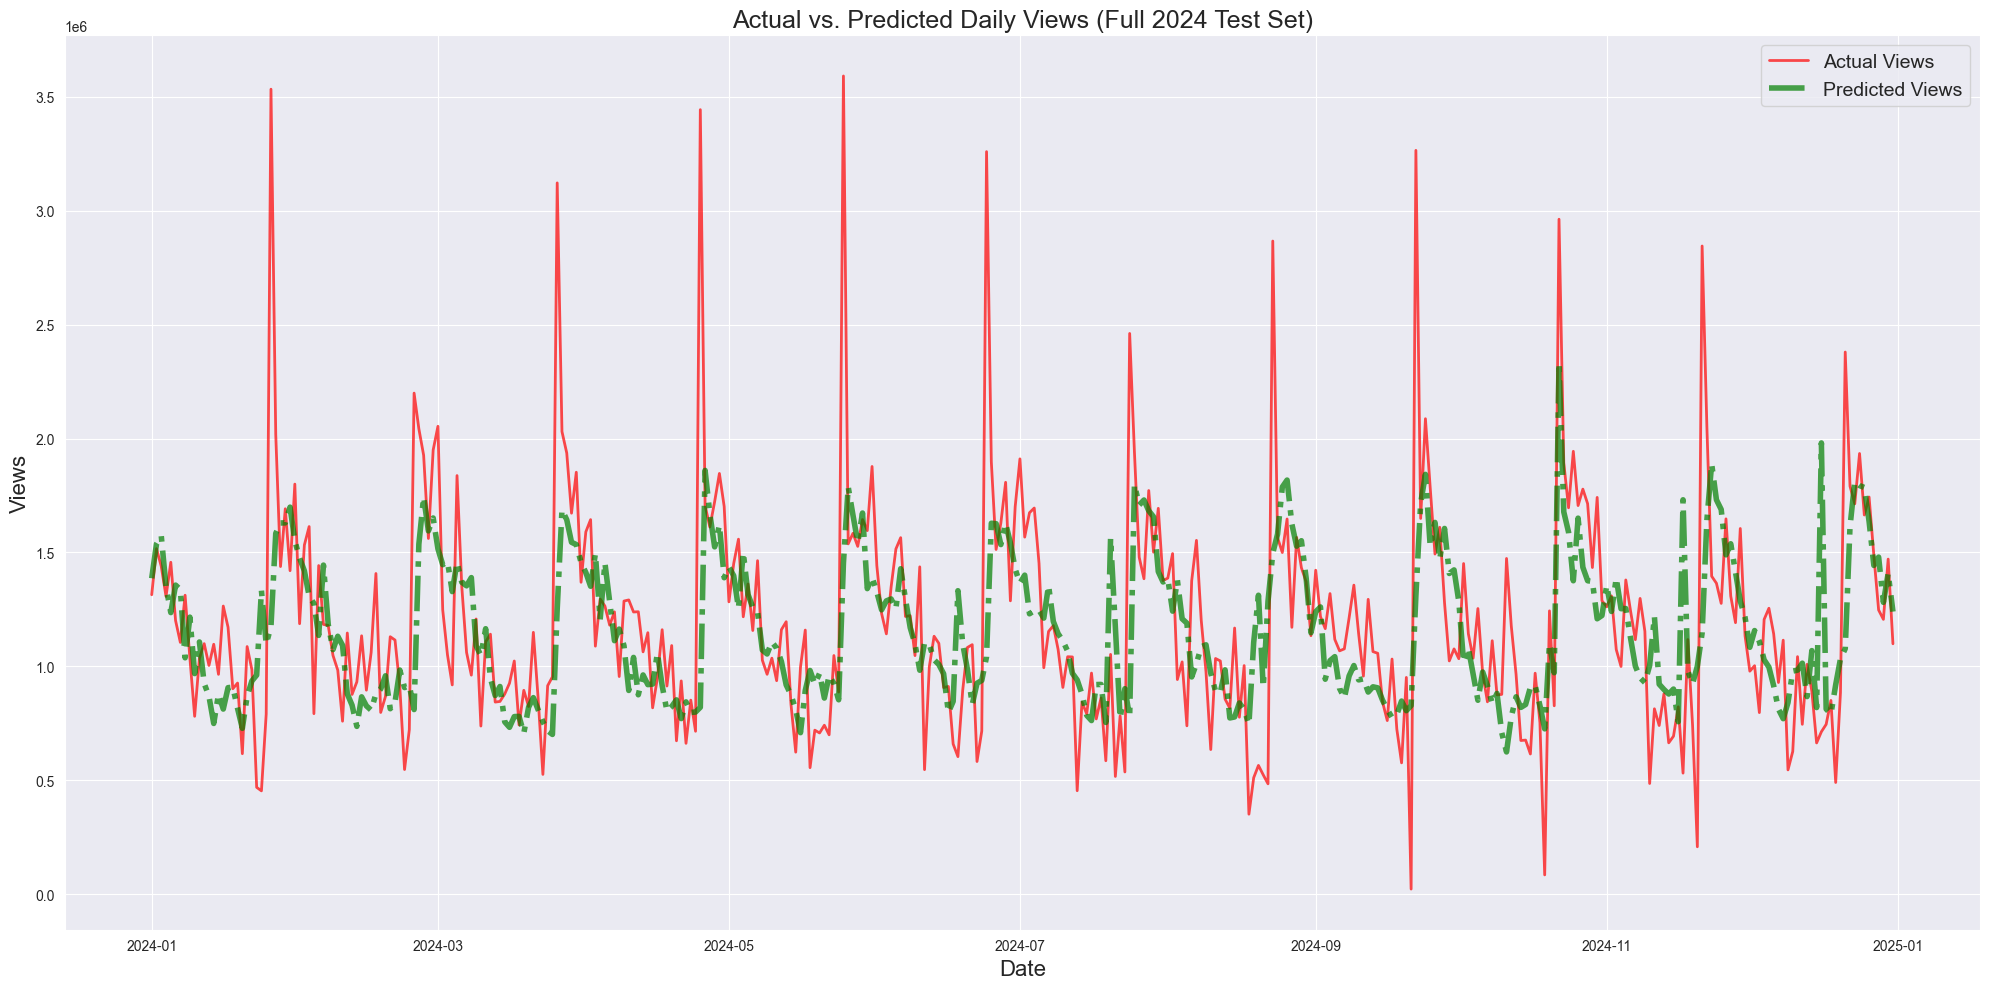

In [21]:
#  Visualize Actual vs. Predicted (Full Test Set) 

sns.set_style("darkgrid") # Style for background plot

plt.figure(figsize=(20, 10)) 

# Plot for ACTUAL views from your test set.
# 'views_actual_test.index' provides the dates for the horizontal (x) axis.
# 'views_actual_test' provides the actual view counts for the vertical (y) axis.
plt.plot(views_actual_test.index, views_actual_test,
label='Actual Views',     
color='red',             
alpha=0.7,                
linewidth=2)             

# Plot for PREDICTED views.
# We use the same dates (views_actual_test.index) so predictions align with actuals.
# 'predictions' is the array of guessed view counts from your model.
plt.plot(views_actual_test.index, predictions,
    label='Predicted Views',   
    color='green',               
    linestyle='-.',            
    alpha=0.7,                 
    linewidth=4)            

# Add a title to your plot for clarity.
plt.title('Actual vs. Predicted Daily Views (Full 2024 Test Set)', fontsize=18)
# Add labels to your axes.
plt.xlabel('Date', fontsize=16)
plt.ylabel('Views', fontsize=16)

plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

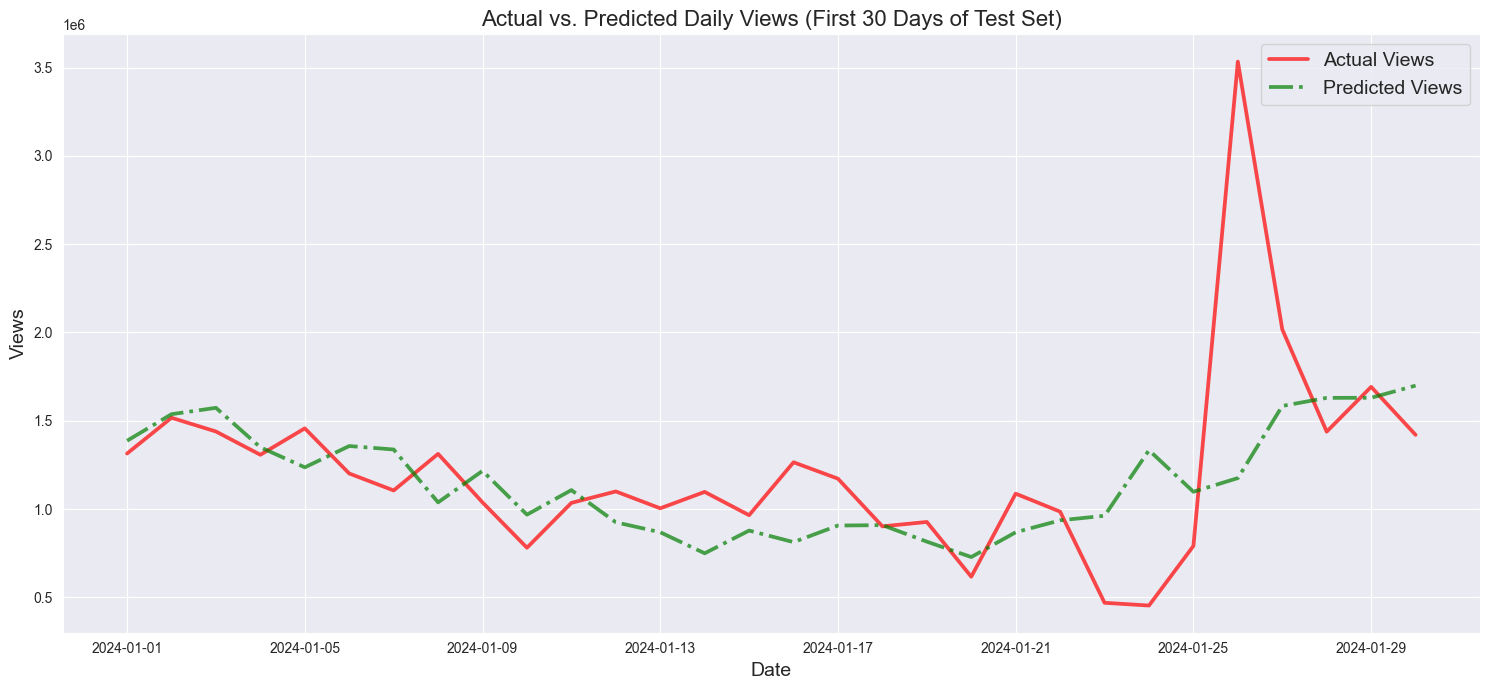

In [25]:
# Visualize Actual vs. Predicted (Zoomed In for first month)

plt.figure(figsize=(15, 7))

# Plot the ACTUAL views for only the first 30 days of the test set.
# The index (dates) for these 30 days are accessed using 'views_actual_test.index[:30]'.
plt.plot(views_actual_test.index[:30], views_actual_test.head(30),
    label='Actual Views',
    color='red',
    alpha=0.7,                
    linewidth=2.7)             

plt.plot(views_actual_test.index[:30], predictions[:30],
    label='Predicted Views',
    color='green',
    linestyle='-.',
    alpha=0.7,
    linewidth=2.7)


plt.title('Actual vs. Predicted Daily Views (First 30 Days of Test Set)', fontsize=16)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Views', fontsize=14)


plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()